# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Przykładowe problemy testowe

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

### Przykład 1:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma^2)$, zaś $\sigma$ jest taka sama dla wszystkich $i = 1, 2, \ldots, d$

In [3]:
sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)

evaluated = objective_function(mutations)
better = mutations[evaluated > objective_function(original_individual)]
print '%d/%d were better' % (better.shape[0], N)
print 'best score: %f' % evaluated.min()

NameError: name 'original_individual' is not defined

### Przykład 2:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma_i^2)$, zaś $\sigma_i$ może być różna dla różnych $i = 1, 2, \ldots, d$

In [16]:
sigma = np.array([0.25, 0.5])
mutations = original_individual + sigma * np.random.randn(N, d)

evaluated = objective_function(mutations)
better = mutations[evaluated > objective_function(original_individual)]
print '%d/%d were better' % (better.shape[0], N)
print 'best score: %f' % evaluated.min()

124/250 were better
best score: -837.749893


### Przykład 3:

$\mathbf{x} = \mathbf{x} + \boldsymbol{\varepsilon}$, gdzie $\boldsymbol{\varepsilon}$ ma wielowymiarowy rozkład normalny $\mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$

In [14]:
S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

evaluated = objective_function(mutations)
better = mutations[evaluated > objective_function(original_individual)]
print '%d/%d were better' % (better.shape[0], N)
print 'best score: %f' % evaluated.min()

129/250 were better
best score: -839.522645


## Przykładowa strategia ewolucyjna

In [43]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas *= np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions += children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1a

Iteration 0000 : best score = -0.02653718, mean score = -6800.58726220.
Iteration 0010 : best score = -0.02653718, mean score = -41.58728049.
Iteration 0020 : best score = -0.00753103, mean score = -0.46596248.
Iteration 0030 : best score = -0.00005190, mean score = -0.01176143.
Iteration 0040 : best score = -0.00000065, mean score = -0.00040327.
Iteration 0050 : best score = -0.00000022, mean score = -0.00000815.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000014.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


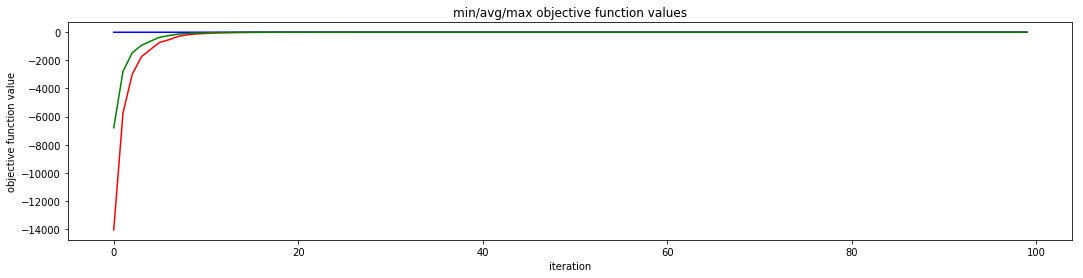

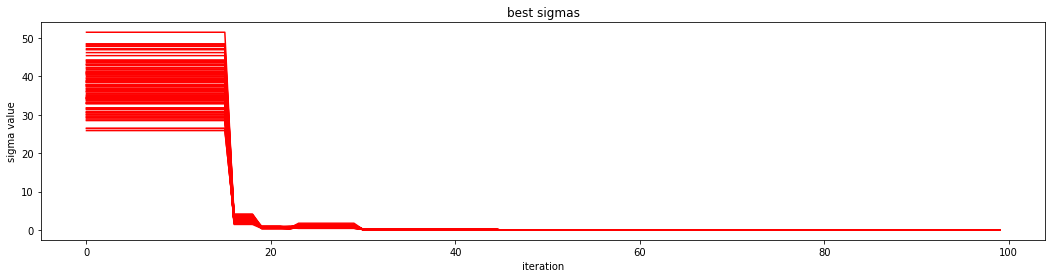

In [44]:
d = 100
N = 100
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1b

Iteration 0000 : best score = -6.49726205, mean score = -235292.36541780.
Iteration 0010 : best score = -1.39555743, mean score = -1729.70068507.
Iteration 0020 : best score = -1.39555743, mean score = -188.27787586.
Iteration 0030 : best score = -0.01169829, mean score = -22.10570873.
Iteration 0040 : best score = -0.00643877, mean score = -3.48739480.
Iteration 0050 : best score = -0.00044177, mean score = -0.60830743.
Iteration 0060 : best score = -0.00004328, mean score = -0.08490836.
Iteration 0070 : best score = -0.00001196, mean score = -0.00957511.
Iteration 0080 : best score = -0.00000090, mean score = -0.00082468.
Iteration 0090 : best score = -0.00000005, mean score = -0.00004783.


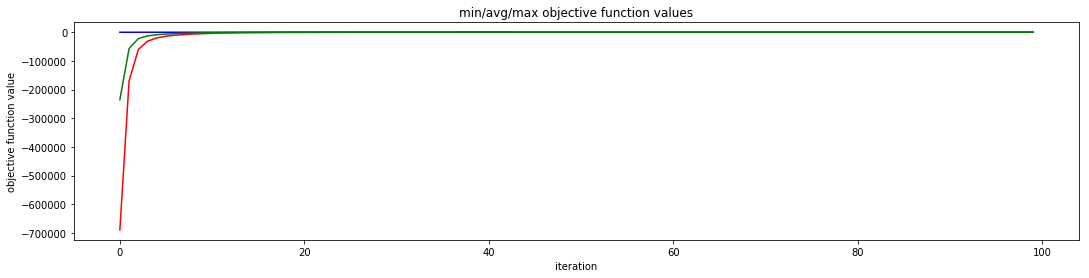

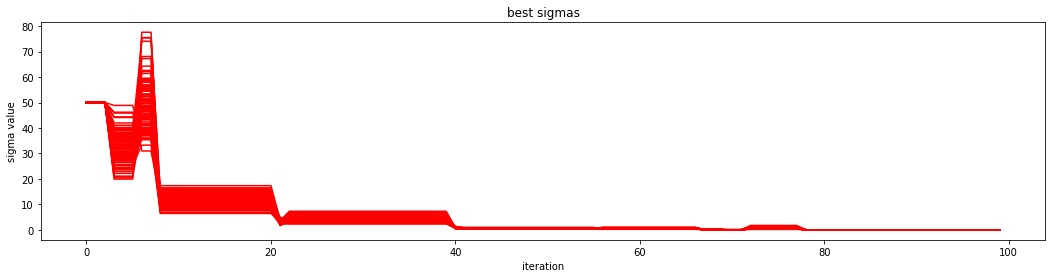

In [45]:
d = 100
N = 1000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1c

Iteration 0000 : best score = -0.52809956, mean score = -1910.09431249.
Iteration 0010 : best score = -0.00226494, mean score = -10.76883502.
Iteration 0020 : best score = -0.00013904, mean score = -0.11179422.
Iteration 0030 : best score = -0.00000206, mean score = -0.00100118.
Iteration 0040 : best score = -0.00000002, mean score = -0.00001417.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000018.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


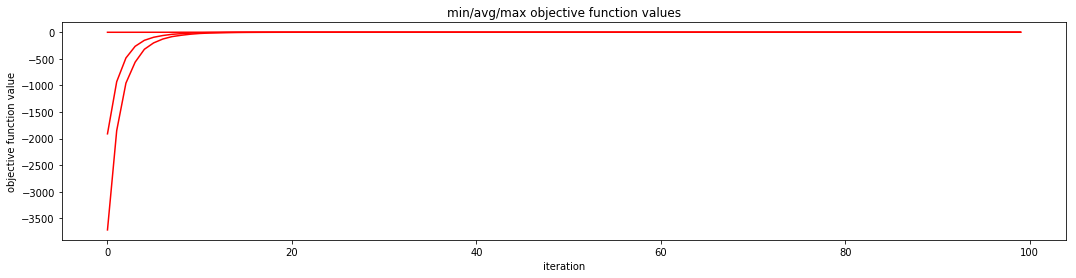

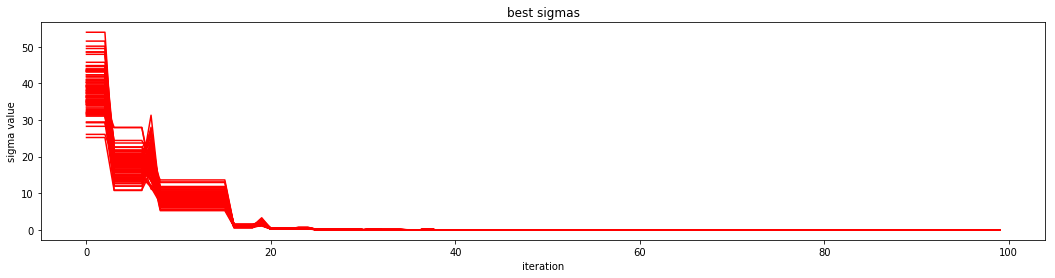

In [46]:
d = 100
N = 1000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

## Uproszczony model mutacji (wer. 1)

In [37]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty(number_of_iterations)

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones(population_size)

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i] = current_population_sigmas[parent_indices[i, :]].mean()

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring) + tau_0 * np.random.randn(number_of_offspring))
        children_population_solutions = children_population_solutions + (children_population_sigmas * np.random.randn(number_of_offspring))[:, None]

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas[:, None], children_population_sigmas[:, None]])[:, 0]
        
        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size]]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t] = current_population_sigmas[0]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1a

Iteration 0000 : best score = -2.27698691, mean score = -4636.01357636.
Iteration 0010 : best score = -0.00021471, mean score = -23.51256791.
Iteration 0020 : best score = -0.00021471, mean score = -2.77941851.
Iteration 0030 : best score = -0.00021471, mean score = -0.52179568.
Iteration 0040 : best score = -0.00021471, mean score = -0.13324137.
Iteration 0050 : best score = -0.00021471, mean score = -0.04200696.
Iteration 0060 : best score = -0.00005312, mean score = -0.01618792.
Iteration 0070 : best score = -0.00004952, mean score = -0.00753515.
Iteration 0080 : best score = -0.00001075, mean score = -0.00374317.
Iteration 0090 : best score = -0.00001075, mean score = -0.00203102.


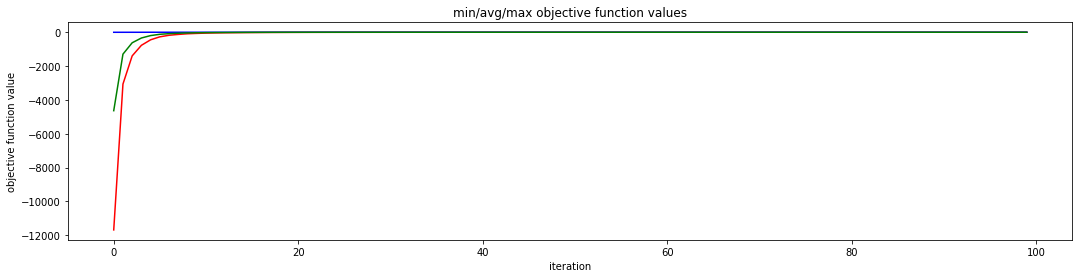

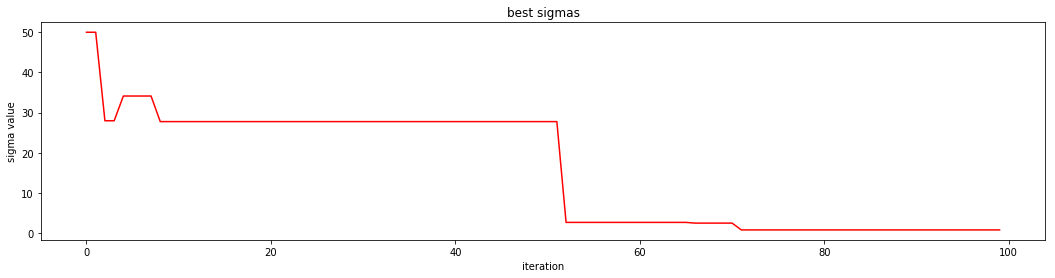

In [38]:
d = 100
N = 1000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1b

Iteration 0000 : best score = -35.28112561, mean score = -72323.67845091.
Iteration 0010 : best score = -0.35040899, mean score = -39.65464587.
Iteration 0020 : best score = -0.00023528, mean score = -0.23600477.
Iteration 0030 : best score = -0.00023528, mean score = -0.00293582.
Iteration 0040 : best score = -0.00006694, mean score = -0.00042424.
Iteration 0050 : best score = -0.00006694, mean score = -0.00015350.
Iteration 0060 : best score = -0.00006694, mean score = -0.00009441.
Iteration 0070 : best score = -0.00006694, mean score = -0.00007722.
Iteration 0080 : best score = -0.00006595, mean score = -0.00007156.
Iteration 0090 : best score = -0.00006595, mean score = -0.00006897.
Iteration 0100 : best score = -0.00006595, mean score = -0.00006797.
Iteration 0110 : best score = -0.00006595, mean score = -0.00006738.
Iteration 0120 : best score = -0.00006595, mean score = -0.00006697.
Iteration 0130 : best score = -0.00006595, mean score = -0.00006669.
Iteration 0140 : best score 

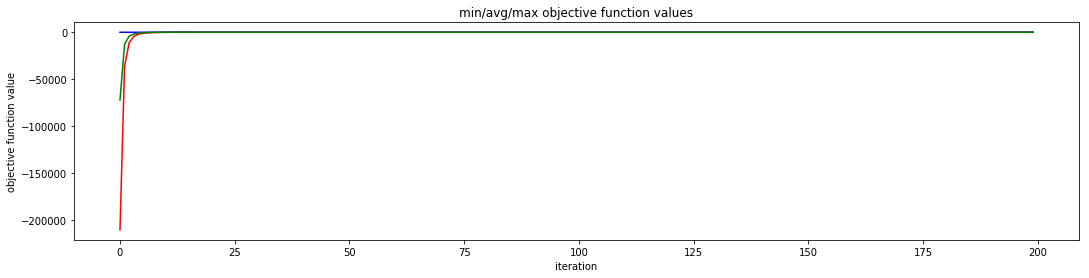

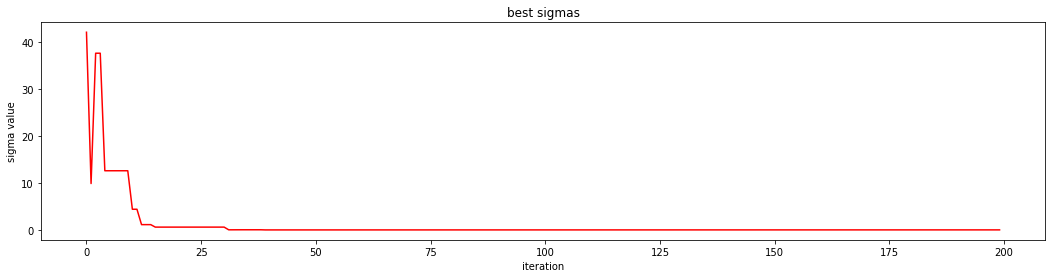

In [40]:
d = 100
N = 2000
T = 200

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 6*N, 2, 100.0, 3/np.sqrt(2*d), 3/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1c

Iteration 0000 : best score = -4.37479158, mean score = -1053.17711661.
Iteration 0010 : best score = -0.00120492, mean score = -1.57767918.
Iteration 0020 : best score = -0.00008293, mean score = -0.09523047.
Iteration 0030 : best score = -0.00002080, mean score = -0.01497947.
Iteration 0040 : best score = -0.00000081, mean score = -0.00362056.
Iteration 0050 : best score = -0.00000081, mean score = -0.00113178.
Iteration 0060 : best score = -0.00000081, mean score = -0.00045160.
Iteration 0070 : best score = -0.00000062, mean score = -0.00021395.
Iteration 0080 : best score = -0.00000007, mean score = -0.00010780.
Iteration 0090 : best score = -0.00000007, mean score = -0.00005604.


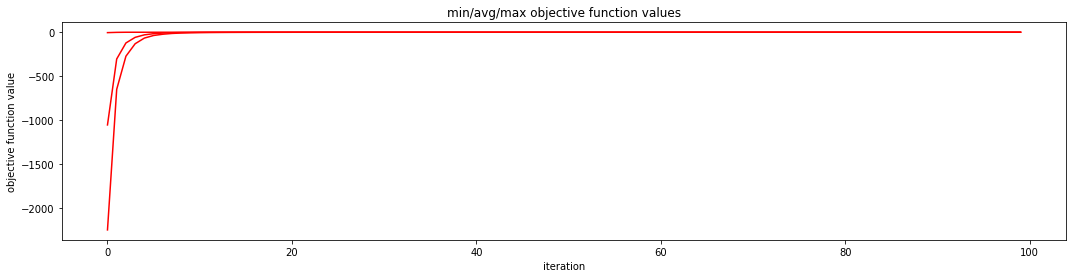

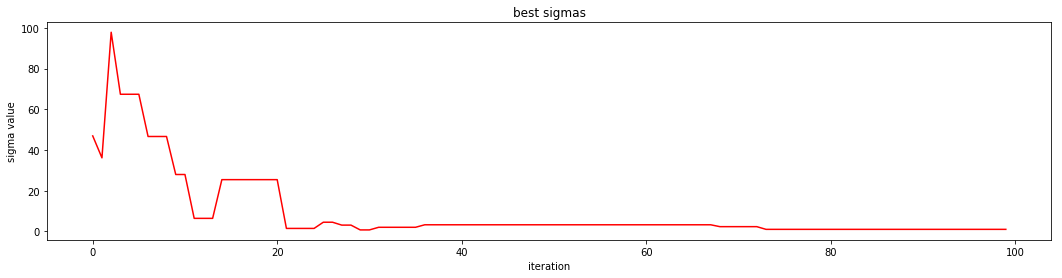

In [27]:
d = 100
N = 1000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()